In [0]:
import numpy as np 
import pandas as pd
import os
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
classes = os.listdir("/content/drive/My Drive/birdd_data_set/bird/CUB_200_2011/train_data")
len(classes)

200

In [0]:
data_dir = "/content/bird-species-classification"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])



train_data = datasets.ImageFolder("/content/drive/My Drive/birdd_data_set/bird/CUB_200_2011/train_data", transform=train_transform)
test_data = datasets.ImageFolder("/content/drive/My Drive/birdd_data_set/bird/CUB_200_2011/test_data", transform=test_transform)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=150, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=150)

len(trainloader)

64

In [0]:
train_data

Dataset ImageFolder
    Number of datapoints: 9460
    Root location: /content/drive/My Drive/birdd_data_set/bird/CUB_200_2011/train_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
tensor(138)
1
tensor(25)


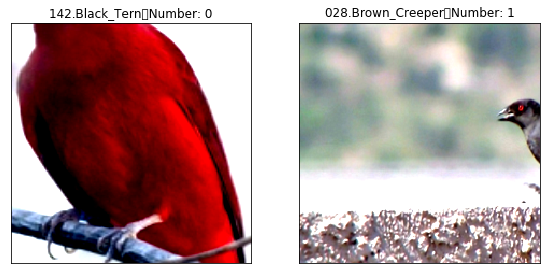

In [0]:
import numpy as np
import matplotlib.pyplot as plt

data_iter = iter(trainloader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    print(idx)
    print(labels[idx])
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    ax.imshow(img, cmap='gray')
    title = classes[labels[idx]] + f"\tNumber: {idx}"
    ax.set_title(title)

In [0]:
model = models.densenet161(pretrained=True)
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
import torch.nn as nn
from collections import OrderedDict

classifier = nn.Sequential(
  nn.Linear(in_features=2208, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=1024, out_features=len(classes)),
  nn.LogSoftmax(dim=1)  
)
    
model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3)
  (3): Linear(in_features=1024, out_features=200, bias=True)
  (4): LogSoftmax()
)

In [0]:
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [0]:
import time

def train_model(model,
                train_loader,
                valid_loader,
                n_epochs,
                optimizer,
                scheduler,
                criterion,
                name="model.pt",
                path=None):
    train_loss_data, valid_loss_data = [], []
    valid_loss_min = np.Inf
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(n_epochs):
        print("Epoch: {}/{}".format(epoch + 1, n_epochs))
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()

        model.train()  
        scheduler.step() 
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        print("\t\tGoing for validation")
        model.eval()
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss_p = criterion(output, target)
            valid_loss += loss_p.item() * data.size(0)
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(correct / total * 100))

        if valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            if path is not None:
                torch.save(model.state_dict(), path)

        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return [model, train_loss_data, valid_loss_data]

In [0]:
total_epoch = 20

In [0]:
model, train_loss, valid_loss = train_model(model, trainloader, testloader,
          total_epoch, optimizer,scheduler, criterion)

Epoch: 1/20
		Going for validation
	Train loss:4.357590.. 	Valid Loss:2.783981.. 	Accuracy: 29.8540
	Validation loss decreased (inf --> 2.783981).  Saving model ...
	Epoch:1 completed in 3m 16s
Epoch: 2/20
		Going for validation
	Train loss:2.801845.. 	Valid Loss:1.861581.. 	Accuracy: 49.5275
	Validation loss decreased (2.783981 --> 1.861581).  Saving model ...
	Epoch:2 completed in 3m 13s
Epoch: 3/20
		Going for validation
	Train loss:2.340271.. 	Valid Loss:1.583168.. 	Accuracy: 56.0567
	Validation loss decreased (1.861581 --> 1.583168).  Saving model ...
	Epoch:3 completed in 3m 12s
Epoch: 4/20
		Going for validation
	Train loss:2.162791.. 	Valid Loss:1.396353.. 	Accuracy: 60.1375
	Validation loss decreased (1.583168 --> 1.396353).  Saving model ...
	Epoch:4 completed in 3m 12s
Epoch: 5/20
		Going for validation
	Train loss:1.988267.. 	Valid Loss:1.270863.. 	Accuracy: 64.0893
	Validation loss decreased (1.396353 --> 1.270863).  Saving model ...
	Epoch:5 completed in 3m 13s
Epoch: 6/2

In [0]:
def testModel(model, loader, device, criterion):
    
    test_loss = 0
    accuracy = 0

    with torch.no_grad():
        
        model.eval()

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print("Train Loss :{:.6f}".format(test_loss),
          "\nAccuracy: {:.4f}".format(accuracy / len(loader) * 100))

In [0]:
testModel(model, testloader, device, criterion)

Train Loss :14.555846 
Accuracy: 73.9647


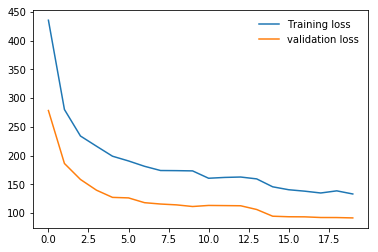

In [0]:
plt.plot(train_loss, label="Training loss")
plt.plot(valid_loss, label="validation loss")
plt.legend(frameon=False)

In [0]:
def test2(model, loader, device, criterion):
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    with torch.no_grad():
        model.eval()
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss = test_loss / len(loader.dataset)
    print('Test Loss: {:.6f}'.format(test_loss))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [0]:
test2(model, trainloader, device, criterion)

Test Loss: 0.998438

Test Accuracy (Overall): 74% (7043/9460)
